In [1]:
import utils
import enumeration
import utils_func
import argparse
import torch
import gc, sys 

from torchvision.transforms import transforms
#import resnet50 architecture
sys.path.append('/media/mary/T7/code/LE_PGD/ablation/models/Sant2019')
from models.Sant2019.resnet import  ResNet50


gc.collect()
torch.cuda.empty_cache()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_names_dict = {
    # "wang2023": "Wang2023Better_WRN-28-10",
    'Sant2019': '/media/mary/T7/code/LE_PGD/ablation/models/Sant2019/ISWASRClassifier_2019_CIFAR10.pt',
    # 'sadajem': '/media/mary/T7/code/LE_PGD/ablation/models/sajem/sadajem5_95.5_9.4.pt'
}

/home/mary/miniconda3/envs/robust/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# parse arguments
parser = argparse.ArgumentParser(description="Process some parameters.")
parser.add_argument("--wandb_logging", type=bool, default=False, help="log to wandb")
parser.add_argument("--batch_size", type=int, default=64, help="batch size")
parser.add_argument(
    "--dataset",
    type=str,
    default="cifar10",
    choices=["cifar10", "cifar100"],
    help="dataset",
)
parser.add_argument("--epsilon", type=float, default=8 / 255, help="epsilon")
parser.add_argument("--alpha", type=float, default=2 / 255, help="alpha")
parser.add_argument(
    "--sampling_iterations", type=int, default=20, help="sampling iterations"
)
parser.add_argument(
    "--architecture_name", type=str, default="WideResNet", help="architecture name"
)
parser.add_argument(
    "--from_robustbench", type=bool, default=True, help="load model from robustbench"
)
parser.add_argument(
    "--init",
    type=str,
    default="random",
    choices=["random", "pca", "gaussian", "informative", "informative+pca"],
    help="initialization for the generation",
)

parser.add_argument("--seed", type=int, default=0, help="random seed")
parser.add_argument("--data_dir", type=str, default="./data", help="data directory")
parser.add_argument(
    "--model_name",
    type=str,
    default="Zhang2019Theoretically",
    choices=[model_names_dict.keys()],
    help="define the name of the model to be loaded",
)
parser.add_argument(
    "--model_source",
    type=str,
    default="robustbench",
    choices=["robustbench", "jem", "local"],
    help="the source from where the model is loaded",
)
parser.add_argument(
    "--model_dir",
    type=str,
    default="./models",
)
parser.add_argument(
    "--threat model",
    type=str,
    default="Linf",
    choices=["Linf", "L2"],
    help="threat model",
)

_StoreAction(option_strings=['--threat model'], dest='threat model', nargs=None, const=None, default='Linf', type=<class 'str'>, choices=['Linf', 'L2'], required=False, help='threat model', metavar=None)

In [3]:

try:
    args = parser.parse_args()
    wandb = args.wandb_logging
    batch_size = args.batch_size
    dataset = args.dataset
    epsilon = args.epsilon
    alpha = args.alpha
    sampling_iterations = args.sampling_iterations
    architecture_name = args.architecture_name
    from_robustbench = args.from_robustbench
    initialization = args.init
    data_dir = args.data_dir
    seed = args.seed
    model_name = args.model_name
    model_source = args.model_source
    model_dir = args.model_dir
    threat_model = args.threat_model

    print("Using arguments from parser")

except:
    print("Using default arguments")
    wandb = False
    batch_size = 64
    dataset = "cifar10"
    epsilon = 8 / 255
    alpha = 2 / 255
    sampling_iterations = 20
    architecture_name = "WideResNet"
    from_robustbench = True
    init = "informative"
    data_dir = "./data"
    seed = 0
    model_name = "jem"
    source = 'robustbench'
    model_dir = "./models"
    threat_model = "L2"

Using default arguments


In [4]:

def fix_seed(seed):
    import torch
    import numpy as np
    import random

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [5]:
# logging on wandb
if wandb:
    import wandb

    config = {
        "dataset": dataset,
        "batch_size": batch_size,
        "epsilon": epsilon,
        "alpha": alpha,
        "sampling_iterations": sampling_iterations,
        "architecture name": architecture_name,
        "from_robustbench": from_robustbench,
        "initialization": init,
        'model name': model_name,
        'model source': model_source
    }
    wandb.init(name="generation", project="LE-PGD",
               entity="le-pgd", config=config)

In [6]:

transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

dataset_train, dataset_test = utils.load_clean_dataset(
    dataset=enumeration.BenchmarkDataset(dataset.lower()),
    n_examples=None,
    data_dir=data_dir,
    transform=transform,
)
train_dataloader = torch.utils.data.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False
)

Files already downloaded and verified
Files already downloaded and verified


## Define and load the model

The default option is to load the model whose name is specified in the arguments 

In [7]:
from robustbench.utils import load_model
from torch import nn

from jem_models import F, CCF
from JEMPP.models.wideresnet import Wide_ResNet as WideResNet



architecture_dict = {'wideresnet': WideResNet, 'resnet50': ResNet50}

assert architecture_name.lower() in architecture_dict.keys()

### Define the model to load 

In [8]:
models = {}
for m_name in model_names_dict.keys():
    models[m_name] = None


In [9]:
for i, model_name_i in enumerate(model_names_dict.keys()):
    model_source = "jem" if model_name_i == "sadajem" else "robustbench"
    model_source = "Sant2019" if model_name_i == "Sant2019" else model_source

    if model_source == "robustbench":
        model = load_model(
            model_name=model_names_dict[model_name_i],
            dataset=dataset,
            threat_model=threat_model,
            model_dir="./models",
        )
        model = nn.DataParallel(model, device_ids=[0])
        model.to(device)
        models[model_name_i] = model.module
    elif model_source == "jem":
        print("loading model from local")

        if dataset == "svhn":
            size = [3, 28, 28]
        else:
            size = [3, 32, 32]

        model_cls = F
        model = model_cls(
            depth=28,
            width=10,
            norm="batch",
            n_classes=enumeration.dataset_num_classes[dataset],
        )
        ckpt_dict = torch.load(model_names_dict["sadajem"])
        model.load_state_dict(ckpt_dict["model_state_dict"])
        model = model.to(device)
        model.eval()
        models[model_name_i] = model

        # replay_buffer = ckpt_dict["replay_buffer"]
    elif model_source == "Sant2019":
        # instanciate resnet 50
        ckpt_dict = torch.load(model_names_dict["Sant2019"])
        ckpt_dict = ckpt_dict['state_dict']
        # load weights
        #remove all the elements that do not start with module
        ckpt_dict = {k: v for k, v in ckpt_dict.items() if 'module' in k and 'attacker'  in k  }
        ckpt_dict = {k.replace('module.', ''): v for k, v in ckpt_dict.items()}
        ckpt_dict = {k.replace('model.', ''): v for k, v in ckpt_dict.items()}
        ckpt_dict = {k.replace('attacker.', ''): v for k, v in ckpt_dict.items()}
        ckpt_dict = {k : v for k, v in ckpt_dict.items() if 'normalize' not in k}
        # print(ckpt_dict.keys())
        
        model = architecture_dict['resnet50'](
            num_classes=enumeration.dataset_num_classes[dataset],
        )
        
        # load weights
        model.load_state_dict(ckpt_dict)
        model = model.to(device)
        model.eval()
        models[model_name_i] = model

    elif model_source == "local":
        model_path = model_dir + "/wandb_model/" + model_name + ".pt"
        # check missimg 2 factors in architecture instanciation
        model = (
            architecture_dict[architecture_name]()
            .to(device)
            .load_state_dict(torch.load(model_path))
            .eval()
        )
        models[model_name_i] = model.module

    del model
    print(f"Model {model_name_i} loaded")

Model Sant2019 loaded


In the cell below there is the computation of the mean of the dataset for each category and then the estimate of the dataset as a GMM where each class is a gaussian distribution

In [10]:
utils_func.category_mean(
    dload_train=train_dataloader,
    n_classes=enumeration.dataset_num_classes[dataset],
    name_dataset=dataset,
    image_size=enumeration.dataset_image_size[dataset],
    n_channels=3,
    data_dir=data_dir,
)
# buffer = utils.center_initialization(
#     dataset=dataset, n_classes=enumeration.dataset_num_classes[dataset], batch_size=batch_size, 
# )
buffer=[]
replay_buffer = []

> Mean and Covariance Already Computed, skipping


## Evaluation of the performance of the model for each initialization

The evaluation focuses on establishing the best way of initializing the generation.
The fixed parameters are :
- generated samples : 12 per class
- labels to generate : a subset of 10 labels 
- seed: defined as argument 
- the norm considered in the perturbation: Linf 
- Loss for the perturbation : energy_xy
- Dataset
- optimizer: SGLD

### In eacho of these plots the images show for each initialization method images generated for 5 classes.
The first line is generated with TRADES -
The second line is generated with MART -
The third line is Wang2023 model, trained on DM generated images https://arxiv.org/pdf/2302.04638.pdf

In [12]:
num_samples = 1
label_to_plot = [i for i in range(2)]
label_to_plot = [[i for i in label_to_plot[:len(label_to_plot) // 2]], [i for i in label_to_plot[len(label_to_plot) // 2:]]]
print(label_to_plot)
loss = 'energy_xy'

[[0], [1]]


### The start is ```informative```

In [ ]:
for labels in label_to_plot:
    init, img = [], []
    for name, model in models.items():
        print(name)

        fix_seed(seed=seed)
        x0, imgs = utils.new_samples(
            model=model,
            label=labels,
            batch_size=num_samples,
            step_size=0.5,
            n_steps=20,
            inizialization="informative",
            n_steps_sampling=1,
            loss=loss,
            replay_buffer=replay_buffer,
            buffer=buffer,
        )
        init.append(x0)
        img.append(imgs)

    init_cat = torch.cat(init, dim=0)
    img_cat = torch.cat(img, dim=0)
    
    utils_func.plot_imgs_generated(
        init_cat,
        inizialization="informative",
        rows= len(model_names_dict.keys()),
        size=(40, 10),
        path="./data/imgs_x0.pdf",
        name="imgs_x0: ",
    )
    utils_func.plot_imgs_generated(
        img_cat,
        inizialization="informative",
        rows=len(model_names_dict.keys()),
        size=(40, 10),
        path="./data/imgs.pdf",
        name="imgs: ",
    )



with n_steps = 50

In [ ]:
for labels in label_to_plot:
    init, img = [], []
    for name, model in models.items():
        print(name)

        fix_seed(seed=seed)
        x0, imgs = utils.new_samples(
            model=model,
            label=labels,
            batch_size=num_samples,
            step_size=0.5,
            n_steps=50,
            inizialization="informative",
            n_steps_sampling=1,
            loss=loss,
            replay_buffer=replay_buffer,
            buffer=buffer,
        )
        init.append(x0)
        img.append(imgs)

    init_cat = torch.cat(init, dim=0)
    img_cat = torch.cat(img, dim=0)
    
    utils_func.plot_imgs_generated(
        init_cat,
        inizialization="informative",
        rows= len(model_names_dict.keys()),
        size=(40, 10),
        path="./data/imgs_x0.pdf",
        name="imgs_x0: ",
    )
    utils_func.plot_imgs_generated(
        img_cat,
        inizialization="informative",
        rows=len(model_names_dict.keys()),
        size=(40, 10),
        path="./data/imgs.pdf",
        name="imgs: ",
    )



### The start is ```pca```

The first attempt is with retained variance equal to 0.80

In [ ]:
for labels in label_to_plot:
    init, img = [], []
    for name, model in models.items():
        print(name)

        fix_seed(seed=seed)
        x0, imgs = utils.new_samples(
            model=model,
            label=labels,
            batch_size=num_samples,
            step_size=0.025,
            n_steps=500,
            inizialization='pca',
            n_steps_sampling=1,
            loss=loss,
            replay_buffer=replay_buffer,
            buffer=buffer,
            
            variance=0.99,
            
            momentum = 0.8,
            alpha = 1, 
            noise_variance = 0.001
            
        )
        init.append(x0)
        img.append(imgs)

    init_cat = torch.cat(init, dim=0)
    img_cat = torch.cat(img, dim=0)

    utils_func.plot_imgs_generated(
        init_cat,
        inizialization="informative",
        rows= len(model_names_dict.keys()),
        size=(40, 10),
        path="./data/imgs_x0.pdf",
        name="imgs_x0: ",
    )
    utils_func.plot_imgs_generated(
        img_cat,
        inizialization="informative",
        rows=len(model_names_dict.keys()),
        size=(40, 10),
        path="./data/imgs.pdf",
        name="imgs: ",
    )

The retained variance is 0.90

In [ ]:
for labels in label_to_plot:
    init, img = [], []
    for name, model in models.items():
        print(name)

        fix_seed(seed=seed)
        x0, imgs = utils.new_samples(
            model=model,
            label=labels,
            batch_size=num_samples,
            step_size=0.8,
            n_steps=20,
            inizialization='pca',
            n_steps_sampling=1,
            loss=loss,
            replay_buffer=replay_buffer,
            buffer=buffer,
            
            variance = 0.90
        )
        init.append(x0)
        img.append(imgs)

    init_cat = torch.cat(init, dim=0)
    img_cat = torch.cat(img, dim=0)

    utils_func.plot_imgs_generated(
        init_cat,
        inizialization="informative",
        rows= len(model_names_dict.keys()),
        size=(40, 10),
        path="./data/imgs_x0.pdf",
        name="imgs_x0: ",
    )
    utils_func.plot_imgs_generated(
        img_cat,
        inizialization="informative",
        rows=len(model_names_dict.keys()),
        size=(40, 10),
        path="./data/imgs.pdf",
        name="imgs: ",
    )

the same retained variance 0.9 but with a n_steps = 50 

In [ ]:
for labels in label_to_plot:
    init, img = [], []
    for name, model in models.items():
        print(name)

        fix_seed(seed=seed)
        x0, imgs = utils.new_samples(
            model=model,
            label=labels,
            batch_size=num_samples,
            step_size=0.8,
            n_steps=50,
            inizialization='pca',
            n_steps_sampling=1,
            loss=loss,
            replay_buffer=replay_buffer,
            buffer=buffer,
            
            variance = 0.90
        )
        init.append(x0)
        img.append(imgs)

    init_cat = torch.cat(init, dim=0)
    img_cat = torch.cat(img, dim=0)

    utils_func.plot_imgs_generated(
        init_cat,
        inizialization="informative",
        rows= len(model_names_dict.keys()),
        size=(40, 10),
        path="./data/imgs_x0.pdf",
        name="imgs_x0: ",
    )
    utils_func.plot_imgs_generated(
        img_cat,
        inizialization="informative",
        rows=len(model_names_dict.keys()),
        size=(40, 10),
        path="./data/imgs.pdf",
        name="imgs: ",
    )

The retained variance is 0.95

In [ ]:
for labels in label_to_plot:
    init, img = [], []
    for name, model in models.items():
        print(name)

        fix_seed(seed=seed)
        x0, imgs = utils.new_samples(
            model=model,
            label=labels,
            batch_size=num_samples,
            step_size=0.8,
            n_steps=20,
            inizialization='pca',
            n_steps_sampling=1,
            loss=loss,
            replay_buffer=replay_buffer,
            buffer=buffer,
            
            variance = 0.95
        )
        init.append(x0)
        img.append(imgs)

    init_cat = torch.cat(init, dim=0)
    img_cat = torch.cat(img, dim=0)

    utils_func.plot_imgs_generated(
        init_cat,
        inizialization="informative",
        rows= len(model_names_dict.keys()),
        size=(40, 10),
        path="./data/imgs_x0.pdf",
        name="imgs_x0: ",
    )
    utils_func.plot_imgs_generated(
        img_cat,
        inizialization="informative",
        rows=len(model_names_dict.keys()),
        size=(40, 10),
        path="./data/imgs.pdf",
        name="imgs: ",
    )

with n_steps = 50

In [ ]:
num_samples = 10

In [ ]:
for labels in label_to_plot:
    init, img = [], []
    for name, model in models.items():
        print(name)

        fix_seed(seed=seed)
        x0, imgs = utils.new_samples(
            model=model,
            label=labels,
            batch_size=num_samples,
            step_size=0.5,
            n_steps=300,
            inizialization='pca',
            n_steps_sampling=1,
            loss=loss,
            replay_buffer=replay_buffer,
            buffer=buffer,
            
            variance = 0.99
        )
        init.append(x0)
        img.append(imgs)

    init_cat = torch.cat(init, dim=0)
    img_cat = torch.cat(img, dim=0)

    utils_func.plot_imgs_generated(
        init_cat,
        inizialization="informative",
        rows= len(model_names_dict.keys()),
        size=(40, 10),
        path="./data/imgs_x0.pdf",
        name="imgs_x0: ",
    )
    utils_func.plot_imgs_generated(
        img_cat,
        inizialization="informative",
        rows=len(model_names_dict.keys()),
        size=(40, 10),
        path="./data/imgs.pdf",
        name="imgs: ",
    )

### The init is ```center```

Sant2019
torch.Size([1, 1, 10, 3072])
the norm is L2


/media/mary/T7/code/LE_PGD/ablation/utils.py:164: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = torch.tensor(buffer[0].sample((batch_size,)).view(-1, *size))


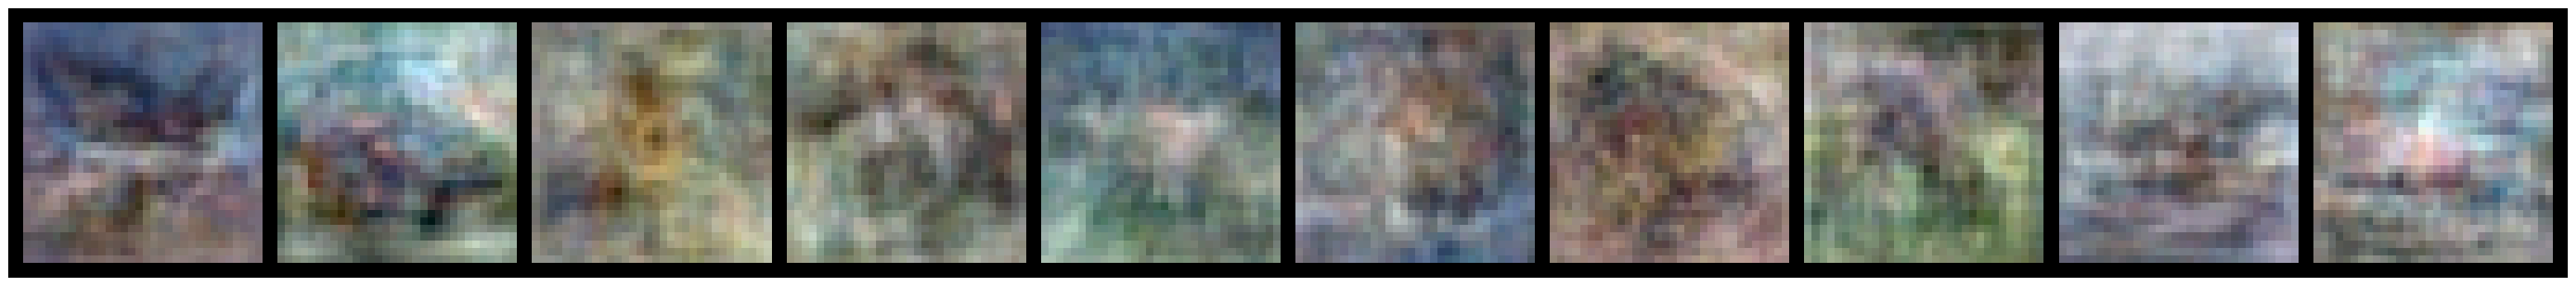

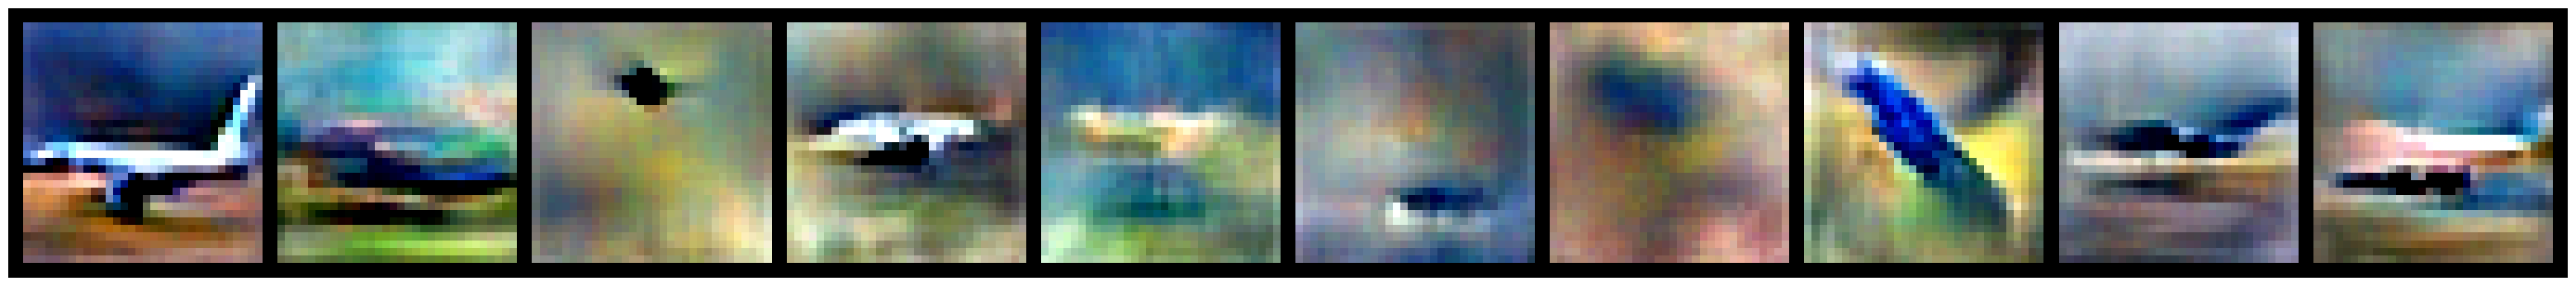

Sant2019


OutOfMemoryError: CUDA out of memory. Tried to allocate 90.00 MiB. GPU 0 has a total capacty of 3.81 GiB of which 64.19 MiB is free. Including non-PyTorch memory, this process has 2.46 GiB memory in use. Of the allocated memory 2.22 GiB is allocated by PyTorch, and 122.49 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [13]:
for labels in label_to_plot:
    init, img = [], []
    for name, model in models.items():
        print(name)

        fix_seed(seed=seed)
        x0, imgs = utils.new_samples(
            model=model,
            label=labels,
            batch_size=num_samples,
            step_size=0.5,
            n_steps=60,
            inizialization='center',
            n_steps_sampling=1,
            loss=loss,
            replay_buffer=replay_buffer,
            buffer=buffer,
            
            eps = 30,
            norm = 'L2'
        )
        init.append(x0)
        img.append(imgs)

    init_cat = torch.cat(init, dim=0)
    img_cat = torch.cat(img, dim=0)

    utils_func.plot_imgs_generated(
        init_cat,
        inizialization="centers",
        rows= len(model_names_dict.keys()),
        size=(40, 10),
        path="./data/imgs_x0.pdf",
        name="imgs_x0: ",
    )
    utils_func.plot_imgs_generated(
        img_cat,
        inizialization="centers",
        rows=len(model_names_dict.keys()),
        size=(40, 10),
        path="./data/imgs.pdf",
        name="imgs: ",
    )